In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nengo
import scipy
import pandas as pd

palette = sns.color_palette('tab10')
sns.set_palette(palette)
sns.set(context='paper', style='white', font="cmr10", font_scale=1.0)
plt.rcParams['axes.formatter.use_mathtext'] = True

In [7]:
class Environment():
    def __init__(self, sid, seed=1, t_load=1, t_cue=0.5, t_reward=0.5, dt=0.001,
                 alpha_plus=0.4, alpha_minus=0.5, gamma_u=0.6,
                 omega_0=0.4, alpha_omega=0.3, gamma_omega=0.1, reward_schedule=1.0):
        self.empirical = pd.read_pickle("data/empirical.pkl")
        self.sid = sid
        self.rng = np.random.RandomState(seed=seed)
        self.t_load = t_load
        self.t_cue = t_cue
        self.t_reward = t_reward
        self.dt = dt
        self.alpha_plus = alpha_plus
        self.alpha_minus = alpha_minus
        self.gamma_u = gamma_u
        self.omega_0 = omega_0
        self.alpha_omega = alpha_omega
        self.gamma_omega = gamma_omega
        self.reward_schedule = reward_schedule
        self.letter  = [0,0]  # [A=-1, B=1]
        self.location = [0,0]  # [left=-1, right=1]
        self.omega = omega_0    # 0 to 1; 0.5 is equal arbitration
        self.reward = [0,0]
        self.alpha = [0,0]
        self.gamma = [0,0]
        self.action = [0,0]
        self.v_chosen = [0,0]
        self.feedback_phase = 0
        self.cue_phase = 1
    def set_cue(self, bid, trial):
        sid = self.sid
        left = self.empirical.query("sid==@sid & bid==@bid & trial==@trial")['left'].to_numpy()[0]
        right = self.empirical.query("sid==@sid & bid==@bid & trial==@trial")['right'].to_numpy()[0]
        self.letter  = [-1, 1] if (left=='A' and right=='B') else [1, -1]
        self.location = [-1, 1]
        self.reward = [0,0]
        self.alpha = [0,0]
        self.gamma = [0,0]
        self.action = [1,1]  # prevents learning during cue phase
        self.v_chosen = [0,0]
        self.cue_phase = 1
        self.feedback_phase = 0
    def set_reward_schedule(self):
        self.reward_schedule = [0.8, 0.7, 0.6][self.rng.randint(3)]
    def set_action(self, sim, net):
        act = sim.data[net.p_action][-1]
        self.action = [1, 0] if act[0]>act[1] else [0,1]
    def set_omega(self, sim, net):
        delta_reliability = self.v_chosen[0] - self.v_chosen[1]
        if delta_reliability > 0:
            self.omega += delta_reliability * self.alpha_omega * (1 - self.omega)  + self.gamma_omega * (self.omega_0 - self.omega)
        else:
            self.omega += np.abs(delta_reliability) * self.alpha_omega * (0 - self.omega) + self.gamma_omega * (self.omega_0 - self.omega)
    def set_reward(self, bid, trial):
        block = self.empirical.query("sid==@sid & bid==@bid & trial==@trial")['block'].to_numpy()[0]
        correct = self.empirical.query("sid==@sid & bid==@bid & trial==@trial")['correct'].to_numpy()[0]
        if self.action==[1,0]:
            if correct=='left':
                if self.rng.uniform(0,1) < self.reward_schedule:    # yes rewarded for picking the better option
                    self.reward = [1,0]
                    self.alpha = [self.alpha_plus,0]
                    self.gamma = [0,self.gamma_u]
                else:                                               # not rewarded for picking the better option
                    self.reward = [-1,0]
                    self.alpha = [self.alpha_minus,0]
                    self.gamma = [0,self.gamma_u]
            else:
                if self.rng.uniform(0,1) < 1-self.reward_schedule:  # yes rewarded for picking the worse option 
                    self.reward = [1,0]
                    self.alpha = [self.alpha_plus,0]
                    self.gamma = [0,self.gamma_u]
                else:                                               # not rewarded for picking the worse option
                    self.reward = [-1,0]
                    self.alpha = [self.alpha_minus,0]
                    self.gamma = [0,self.gamma_u]
        else:
            if correct=='right':
                if self.rng.uniform(0,1) < self.reward_schedule:    # yes rewarded for picking the better option
                    self.reward = [0,1]
                    self.alpha = [0, self.alpha_plus]
                    self.gamma = [self.gamma_u,0]
                else:                                               # not rewarded for picking the better option
                    self.reward = [0,-1]  
                    self.alpha = [0, self.alpha_minus]
                    self.gamma = [self.gamma_u,0]
            else:
                if self.rng.uniform(0,1) < 1-self.reward_schedule:  # yes rewarded for picking the worse option
                    self.reward = [0,1] 
                    self.alpha = [0, self.alpha_plus]
                    self.gamma = [self.gamma_u,0]
                else:                                               # not rewarded for picking the worse option   
                    self.reward = [0,-1]           
                    self.alpha = [0, self.alpha_minus]
                    self.gamma = [self.gamma_u,0]
        self.cue_phase = 0
        self.feedback_phase = 1
    def set_v_chosen(self, sim, net):
        chosen = 0 if self.action==[1,0] else 1
        v_c_letter = sim.data[net.p_value_letter][-1,chosen]
        v_c_location = sim.data[net.p_value_location][-1,chosen]
        self.v_chosen = [v_c_letter, v_c_location]
    def sample_letter(self, t):
        return self.letter
    def sample_location(self, t):
        return self.location
    def sample_omega(self, t):
        return self.omega
    def sample_reward(self, t):
        return self.reward
    def sample_alpha(self, t):
        return self.alpha
    def sample_gamma(self, t):
        return self.gamma
    def sample_action(self, t):
        return self.action
    def sample_unchosen(self, t):
        return [1-self.action[0], 1-self.action[1]]
    def sample_phase(self, t):
        return [self.cue_phase, self.feedback_phase]
    def sample_v_chosen(self, t):
        return [self.v_chosen[0], self.v_chosen[1]]

In [38]:
def build_network(env, n_neurons=1000, seed_network=1, inh=0, k=0.2, a=4e-5):
    net = nengo.Network(seed=seed_network)
    net.env = env
    net.config[nengo.Connection].synapse = 0.01
    net.config[nengo.Probe].synapse = 0.1
    w_fb = np.array([[1, inh], [inh, 1]])
    inh_feedback = -1000*np.ones((n_neurons, 1))
    pes = nengo.PES(learning_rate=a)

    with net:
        in_letter = nengo.Node(lambda t: env.sample_letter(t))
        in_location = nengo.Node(lambda t: env.sample_location(t))
        in_omega = nengo.Node(lambda t: env.omega_0)
        in_reward = nengo.Node(lambda t: env.sample_reward(t))
        in_alpha = nengo.Node(lambda t: env.sample_alpha(t))
        in_gamma = nengo.Node(lambda t: env.sample_gamma(t))
        in_phase = nengo.Node(lambda t: env.sample_phase(t))
        in_unchosen = nengo.Node(lambda t: env.sample_unchosen(t))
        in_v_chosen = nengo.Node(lambda t: env.sample_v_chosen(t))
        target_omega = nengo.Node(lambda t: env.sample_omega(t))
        stop_load = nengo.Node(lambda t: 1 if t>env.t_load else 0)
        diff_output = nengo.Node(size_in=1)
        
        letter = nengo.Ensemble(n_neurons, 2, radius=2)
        location = nengo.Ensemble(n_neurons, 2, radius=2)
        omega = nengo.Ensemble(n_neurons, 1)
        value_letter = nengo.Ensemble(n_neurons, 3, radius=3)
        value_location = nengo.Ensemble(n_neurons, 3, radius=3)
        value_left = nengo.Ensemble(n_neurons, 1)
        value_right = nengo.Ensemble(n_neurons, 1)
        reward = nengo.Ensemble(n_neurons, 2)
        alpha = nengo.Ensemble(n_neurons, 2)
        gamma = nengo.Ensemble(n_neurons, 2)
        action = nengo.Ensemble(n_neurons, 2)
        error = nengo.Ensemble(n_neurons, 4, radius=3)
        decay = nengo.Ensemble(n_neurons, 4, radius=3)
        load = nengo.Ensemble(n_neurons, 1)
        relax = nengo.Ensemble(n_neurons, 1)
        diff = nengo.Ensemble(n_neurons, 3, radius=2)
        delta_rel = nengo.Ensemble(n_neurons, 2)
        
        nengo.Connection(in_letter, letter, synapse=None)
        nengo.Connection(in_location, location, synapse=None)
        nengo.Connection(in_reward, reward, synapse=None)
        nengo.Connection(in_alpha, alpha, synapse=None)
        nengo.Connection(in_gamma, gamma, synapse=None)

        nengo.Connection(in_omega, load)
        nengo.Connection(in_omega, relax)
        nengo.Connection(load, omega)
        nengo.Connection(relax, omega, transform=env.gamma_omega*0.1)
        nengo.Connection(omega, load, transform=-1)
        nengo.Connection(omega, relax, transform=-1)
        nengo.Connection(stop_load, load.neurons, transform=inh_feedback)
        nengo.Connection(in_phase[0], relax.neurons, transform=inh_feedback)
        
        nengo.Connection(omega, omega, synapse=0.1)

        # update omega by Delta_Rel
        nengo.Connection(in_v_chosen, delta_rel)
        nengo.Connection(delta_rel, diff[0], function=lambda x: np.abs(x[0]-x[1]))
        nengo.Connection(delta_rel, diff[1], function=lambda x: 1 if x[0]>x[1] else 0)
        nengo.Connection(omega, diff[2])
        nengo.Connection(diff, omega, function=lambda x: 0.05*x[0]*(x[1]-x[2]))
        nengo.Connection(diff, diff_output, function=lambda x: x[0]*(x[1]-x[2]))
        nengo.Connection(in_phase[0], diff.neurons, transform=inh_feedback)
        
        c0 = nengo.Connection(letter[0], value_letter[0], transform=0, learning_rule_type=pes)
        c1 = nengo.Connection(letter[1], value_letter[1], transform=0, learning_rule_type=pes)
        c2 = nengo.Connection(location[0], value_location[0], transform=0, learning_rule_type=pes)
        c3 = nengo.Connection(location[1], value_location[1], transform=0, learning_rule_type=pes)
        nengo.Connection(omega, value_letter[2])
        nengo.Connection(omega, value_location[2])

        nengo.Connection(value_letter, value_left, function=lambda x: x[0]*x[2])
        nengo.Connection(value_location, value_left, function=lambda x: x[0]*(1-x[2]))
        nengo.Connection(value_letter, value_right, function=lambda x: x[1]*x[2])
        nengo.Connection(value_location, value_right, function=lambda x: x[1]*(1-x[2]))
        
        nengo.Connection(value_left, action[0], transform=k)
        nengo.Connection(value_right, action[1], transform=k)
        nengo.Connection(action, action, transform=w_fb, synapse=0.1)

        nengo.Connection(in_phase[0], error.neurons, transform=inh_feedback, synapse=None)
        nengo.Connection(in_phase[0], decay.neurons, transform=inh_feedback, synapse=None)
        nengo.Connection(in_phase[1], action.neurons, transform=inh_feedback, synapse=None)

        nengo.Connection(value_letter[0], error[0], transform=-1)
        nengo.Connection(value_letter[1], error[1], transform=-1)
        nengo.Connection(value_location[0], error[0], transform=-1)
        nengo.Connection(value_location[1], error[1], transform=-1)
        nengo.Connection(reward[0], error[0], transform=+1)
        nengo.Connection(reward[1], error[1], transform=+1)
        nengo.Connection(alpha[0], error[2])
        nengo.Connection(alpha[1], error[3])

        nengo.Connection(error, c0.learning_rule, function=lambda x: -x[0]*x[2])
        nengo.Connection(error, c2.learning_rule, function=lambda x: -x[0]*x[2])
        nengo.Connection(error, c1.learning_rule, function=lambda x: -x[1]*x[3])
        nengo.Connection(error, c3.learning_rule, function=lambda x: -x[1]*x[3])

        nengo.Connection(value_letter[0], decay[0], transform=-1)
        nengo.Connection(value_letter[1], decay[1], transform=-1)
        nengo.Connection(value_location[0], decay[0], transform=-1)
        nengo.Connection(value_location[1], decay[1], transform=-1)
        nengo.Connection(gamma[0], decay[2])
        nengo.Connection(gamma[1], decay[3])

        nengo.Connection(decay, c0.learning_rule, function=lambda x: -x[0]*x[2])
        nengo.Connection(decay, c2.learning_rule, function=lambda x: -x[0]*x[2])
        nengo.Connection(decay, c1.learning_rule, function=lambda x: -x[1]*x[3])
        nengo.Connection(decay, c3.learning_rule, function=lambda x: -x[1]*x[3])
    
        net.p_letter = nengo.Probe(letter)
        net.p_location = nengo.Probe(location)
        net.p_value_letter = nengo.Probe(value_letter)
        net.p_value_location = nengo.Probe(value_location)
        net.p_value_left = nengo.Probe(value_left)
        net.p_value_right = nengo.Probe(value_right)
        net.p_reward = nengo.Probe(reward)
        net.p_action = nengo.Probe(action)
        net.p_alpha = nengo.Probe(alpha)
        net.p_gamma = nengo.Probe(gamma)
        net.p_error = nengo.Probe(error)
        net.p_decay = nengo.Probe(decay)
        net.p_delta_rel = nengo.Probe(delta_rel)
        net.p_diff = nengo.Probe(diff)
        net.p_diff_output = nengo.Probe(diff_output)
        net.p_omega = nengo.Probe(omega)
        net.p_omega_target = nengo.Probe(target_omega)

    return net

In [39]:
def plot_network(net, bids=[1], trials=10):
    sim = nengo.Simulator(net, dt=net.env.dt, progress_bar=False)    
    with sim:
        sim.run(net.env.t_load)
        for bid in bids:
            # env.set_reward_schedule()
            env.reward_schedule = 0.9
            for trial in net.env.empirical.query("sid==@sid & bid==@bid")['trial'].unique()[:trials]:
                print(f"running sid {net.env.sid}, block {bid}, trial {trial}")
                net.env.set_cue(bid, trial)
                sim.run(net.env.t_cue)
                env.set_action(sim, net)
                env.set_v_chosen(sim, net)
                env.set_omega(sim, net)
                env.set_reward(bid, trial)
                sim.run(net.env.t_reward)
    return sim

In [40]:
def simulate_network(net, blocks=24):
    dfs = []
    columns = ['sid', 'bid', 'reward_schedule', 'trial_before_reversal', 'trial_after_reversal', 'accuracy']
    env = net.env
    sid = env.sid
    sim = nengo.Simulator(net, dt=env.dt, progress_bar=False)
    with sim:
        sim.run(net.env.t_load)
        for bid in env.empirical.query("sid==@sid")['bid'].unique()[:blocks]:
            env.set_reward_schedule()
            for trial in env.empirical.query("sid==@sid & bid==@bid")['trial'].unique():
                print(f"running sid {env.sid}, block {bid}, trial {trial}")
                env.set_cue(bid, trial)
                sim.run(env.t_cue)
                env.set_action(sim, net)
                env.set_v_chosen(sim, net)
                env.set_omega(sim, net)
                env.set_reward(bid, trial)
                sim.run(env.t_reward)
                # did they choose the better option?
                block = env.empirical.query("sid==@sid & bid==@bid & trial==@trial")['block'].to_numpy()[0]
                correct = env.empirical.query("sid==@sid & bid==@bid & trial==@trial")['correct'].to_numpy()[0]
                if env.action==[1,0] and correct=='left':
                    accuracy = 1
                elif env.action==[0,1] and correct=='right':
                    accuracy = 1
                else:
                    accuracy = 0
                reversal_at_trial = env.empirical.query("sid==@sid & bid==@bid")['reversal_at_trial'].unique()[0]
                trial_before_reversal = trial if trial<reversal_at_trial else None
                trial_after_reversal = trial - reversal_at_trial if trial>=reversal_at_trial else None
                dfs.append(pd.DataFrame([[sid, bid, env.reward_schedule, trial_before_reversal, trial_after_reversal, accuracy]], columns=columns))
    data = pd.concat(dfs, ignore_index=True)
    return sim, data

## Dynamics

In [43]:
sid = 1
bids = [13]
env = Environment(sid=sid)
net = build_network(env)
sim = plot_network(net, bids=bids, trials=80)

running sid 1, block 13, trial 1
running sid 1, block 13, trial 2
running sid 1, block 13, trial 3
running sid 1, block 13, trial 4
running sid 1, block 13, trial 5
running sid 1, block 13, trial 6
running sid 1, block 13, trial 7
running sid 1, block 13, trial 8
running sid 1, block 13, trial 9
running sid 1, block 13, trial 10
running sid 1, block 13, trial 11
running sid 1, block 13, trial 12
running sid 1, block 13, trial 13
running sid 1, block 13, trial 14
running sid 1, block 13, trial 15
running sid 1, block 13, trial 16
running sid 1, block 13, trial 17
running sid 1, block 13, trial 18
running sid 1, block 13, trial 19
running sid 1, block 13, trial 20
running sid 1, block 13, trial 21
running sid 1, block 13, trial 22
running sid 1, block 13, trial 23
running sid 1, block 13, trial 24
running sid 1, block 13, trial 25
running sid 1, block 13, trial 26
running sid 1, block 13, trial 27
running sid 1, block 13, trial 28
running sid 1, block 13, trial 29
running sid 1, block 13

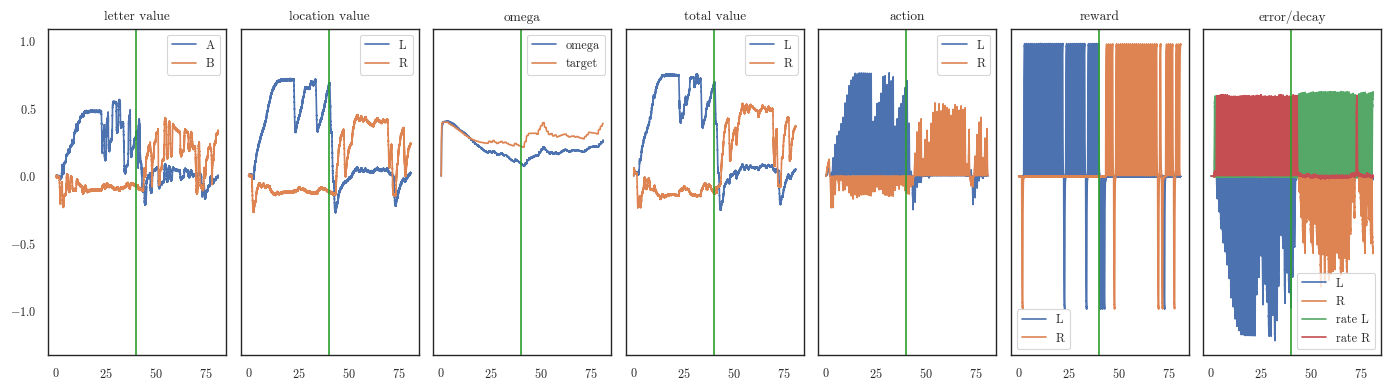

In [46]:
fig, axes = plt.subplots(nrows=1, ncols=7, sharey=True, figsize=(14, 4))
axes[0].plot(sim.trange(), sim.data[net.p_value_letter][:,0], label='A')
axes[0].plot(sim.trange(), sim.data[net.p_value_letter][:,1], label='B')
axes[1].plot(sim.trange(), sim.data[net.p_value_location][:,0], label='L')
axes[1].plot(sim.trange(), sim.data[net.p_value_location][:,1], label='R')
axes[2].plot(sim.trange(), sim.data[net.p_omega], label='omega')
axes[2].plot(sim.trange(), sim.data[net.p_omega_target], label='target')
# axes[2].plot(sim.trange(), sim.data[net.p_diff][:,0], label='delta rel')
# axes[2].plot(sim.trange(), sim.data[net.p_diff][:,1], label='sign')
# axes[2].plot(sim.trange(), sim.data[net.p_diff][:,2], label='omega in diff')
# axes[2].plot(sim.trange(), sim.data[net.p_delta_rel], label='delta_rel')
# axes[2].plot(sim.trange(), sim.data[net.p_diff_output], label='diff_output')
axes[3].plot(sim.trange(), sim.data[net.p_value_left], label='L')
axes[3].plot(sim.trange(), sim.data[net.p_value_right], label='R')
axes[4].plot(sim.trange(), sim.data[net.p_action][:,0], label='L')
axes[4].plot(sim.trange(), sim.data[net.p_action][:,1], label='R')
axes[5].plot(sim.trange(), sim.data[net.p_reward][:,0], label='L')
axes[5].plot(sim.trange(), sim.data[net.p_reward][:,1], label='R')
# axes[6].plot(sim.trange(), sim.data[net.p_error][:,0], label='L')
# axes[6].plot(sim.trange(), sim.data[net.p_error][:,1], label='R')
# axes[6].plot(sim.trange(), sim.data[net.p_error][:,2], label='rate L')
# axes[6].plot(sim.trange(), sim.data[net.p_error][:,3], label='rate R')
axes[6].plot(sim.trange(), sim.data[net.p_decay][:,0], label='L')
axes[6].plot(sim.trange(), sim.data[net.p_decay][:,1], label='R')
axes[6].plot(sim.trange(), sim.data[net.p_decay][:,2], label='rate L')
axes[6].plot(sim.trange(), sim.data[net.p_decay][:,3], label='rate R')
# axes[0].set(title='value of choose L')
# axes[1].set(title='value of choose R')
axes[0].set(title='letter value')
axes[1].set(title='location value')
axes[2].set(title='omega')
axes[3].set(title='total value')
axes[4].set(title='action')
axes[5].set(title='reward')
axes[6].set(title='error/decay')
axes[0].legend()
axes[1].legend()
axes[2].legend()
axes[3].legend()
axes[4].legend()
axes[5].legend()
axes[6].legend()
# axes[0].axvline(env.t_load, color=palette[3])
# axes[1].axvline(env.t_load, color=palette[3])
# axes[2].axvline(env.t_load, color=palette[3])
# axes[3].axvline(env.t_load, color=palette[3])
# axes[4].axvline(env.t_load, color=palette[3])
# axes[5].axvline(env.t_load, color=palette[3])
# axes[6].axvline(env.t_load, color=palette[3])
for bid in bids:
    reversal_at_trial = env.empirical.query("sid==@sid & bid==@bid")['reversal_at_trial'].unique()[0]
    axes[0].axvline(reversal_at_trial, color=palette[2])
    axes[1].axvline(reversal_at_trial, color=palette[2])
    axes[2].axvline(reversal_at_trial, color=palette[2])
    axes[3].axvline(reversal_at_trial, color=palette[2])
    axes[4].axvline(reversal_at_trial, color=palette[2])
    axes[5].axvline(reversal_at_trial, color=palette[2])
    axes[6].axvline(reversal_at_trial, color=palette[2])
fig.tight_layout()

# fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(4, 2))
# axes[0].plot(sim.trange(), sim.data[net.p_letter], label='letter')
# axes[1].plot(sim.trange(), sim.data[net.p_location], label='location')
# axes[0].set(title="letter")
# axes[1].set(title="location")
# fig.tight_layout()

## All data

In [ ]:
sid = 1
env = Environment(sid=sid)
net = build_network(env)
sim, data = simulate_network(net)

## Simulate all behavioral data

In [ ]:
empirical = pd.read_pickle("data/empirical.pkl")
dfs = []
for sid in empirical['sid'].unique():
    env = Environment(sid=sid)
    net = build_network(env)
    sim, data = simulate_network(net)
    dfs.append(data)
simulated = pd.concat(dfs, ignore_index=True)
simulated.to_pickle("data/simulated.pkl")

## Load

In [ ]:
empirical = pd.read_pickle("data/empirical.pkl")
dfs = []
for sid in empirical['sid'].unique():
    data = pd.read_pickle(f"data/model0_sid{sid}_behavior.pkl")
    dfs.append(data)
simulated = pd.concat(dfs, ignore_index=True)
simulated.to_pickle("data/simulated.pkl")

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(8, 4))
sns.lineplot(simulated, x='trial_before_reversal', y='accuracy', hue='reward_schedule', palette=palette[:3], ax=axes[0])
sns.lineplot(simulated, x='trial_after_reversal', y='accuracy', hue='reward_schedule', palette=palette[:3], ax=axes[1])
axes[1].get_legend().remove()
axes[0].set(ylabel="P(Better)", xlabel='Trial (before reversal)')
axes[1].set(xlabel='Trial (after reversal)')
fig.tight_layout()